# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [3]:
colab = True  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
if colab:
    anime = pd.read_csv('/content/drive/MyDrive/ml-courses/ml-advanced/anime.csv')
else:
    anime = pd.read_csv('../data/anime/anime.csv.zip')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
if colab:
    ratings = pd.read_csv('/content/drive/MyDrive/ml-courses/ml-advanced/rating.csv')
else:
    ratings = pd.read_csv('../data/anime/rating.csv.zip')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет.

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут.

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее.

### 1. Избавьтесь от -1

In [6]:
ratings = ratings.query('rating != 0 and rating != -1')
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn.

In [7]:
from scipy.special import erfc

def chauvenet(array):
    mean = np.mean(array)
    std = np.std(array)
    N = len(array)

    criterion = 1.0 / (2 * N)
    deviation = np.abs(array - mean) / std
    probability = erfc(deviation)

    mask = erfc(deviation) < criterion
    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [8]:
count_reviews = ratings.groupby('user_id')['anime_id'].count().reset_index(name='count')
count_reviews.set_index('user_id', inplace=True)
count_reviews

,count
user_id,
1,4
2,1
3,92
5,459
7,343
...,...
73512,12
73513,33
73514,1


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [9]:
outlier_users = count_reviews[chauvenet(count_reviews['count'].values)]
outlier_users

,count
user_id,
226,742
271,599
294,675
392,598
446,743
...,...
73356,565
73362,596
73378,723


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**
1. Критерий посчитал выбросом пользователей, имеющих такое количество просмотренных аниме, которое значительно отличается от среднего значения в выборке.
2. Критерий Шавене определяет выбросы как значения, которые находятся далеко от среднего значения по сравнению с другими данными в выборке. Это достигается путем вычисления нормализованного отклонения (количество стандартных отклонений от среднего) и проверки, находится ли вероятность наблюдения такого отклонения ниже определенного порога (1/2N). Если вероятность слишком мала, значение считается выбросом.
3. Пользователям, которые просмотрели значительно больше аниме, чем большинство (выбросы), рекомендательная система может быть не так важна, так как они, вероятно, уже имеют хорошие знания о существующих аниме и, возможно, находят новые сами. Однако пользователи, которые просмотрели значительно меньше аниме, могут нуждаться в рекомендациях, чтобы найти интересные аниме и увеличить количество просмотров.

In [10]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

count    522
dtype: int64

Если все было правильно `bad_user_threshold` больше 500.

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [11]:
count_reviews.rename(columns={'count': 'count_reviews'}, inplace=True)
merged_df = ratings.merge(count_reviews, on='user_id')
ratings = merged_df[merged_df['count_reviews'] < bad_user_threshold['count']]
ratings

,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1
...,...,...,...,...
6337236,73515,16512,7,179
6337237,73515,17187,9,179
6337238,73515,22145,10,179
6337239,73516,790,9,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [12]:
median = ratings['count_reviews'].median()
ratings = ratings[ratings['count_reviews'] >= median]
ratings

,user_id,anime_id,rating,count_reviews
97,5,6,8,459
98,5,15,6,459
99,5,17,6,459
100,5,18,6,459
101,5,20,6,459
...,...,...,...,...
6337234,73515,13659,8,179
6337235,73515,14345,7,179
6337236,73515,16512,7,179
6337237,73515,17187,9,179


In [13]:
# Удалим столбец с просмотрами чтобы не мешал.

ratings = ratings.drop(columns=['count_reviews'])

Теперь рассмотрим таблицу `anime`.


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [14]:
outlier_anime = anime[chauvenet(anime['members'].values)]
anime = anime.drop(outlier_anime.index)
anime

,anime_id,name,genre,type,episodes,rating,members
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе?

**Ответы:**
1. Критерий Шавене посчитал выбросами те аниме, которые имеют количество членов (members) значительно отклоняющееся от среднего значения для всех аниме. Это могут быть как аниме с очень большим количеством членов, так и с очень малым количеством членов.
2. Критерий Шавене использует стандартное отклонение и среднее значение для определения того, насколько далеко данные отклоняются от среднего значения. Если значение members аниме настолько сильно отклоняется от среднего, что вероятность наблюдения такого отклонения становится меньше, чем порог, установленный критерием (обычно это 1/N, где N — количество наблюдений), то эти данные считаются выбросами. Таким образом, аниме с необычно большим или малым количеством членов были определены как выбросы.
3. Аниме с очень большим количеством членов могут быть популярными и часто рекомендоваться новым пользователям или тем, кто еще не видел эти хиты. Это поможет повысить пользовательскую удовлетворенность, рекомендуя популярные и высоко оцененные аниме. Выбросы могут помочь в анализе аудитории и выявлении различных сегментов пользователей. Например, если некоторые аниме очень популярны среди определенной группы пользователей, это может быть полезно для таргетированных рекомендаций.

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы.

In [15]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [16]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Comedy, Drama, School, Shounen, Sports' 'Drama, Military, Sci-Fi, Space'
 'Drama, School, Shounen'
 'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural'
 'Comedy, Drama, Shounen, Sports'
 'Action, Drama, Historical, Martial Arts, Romance, Samurai'
 'Drama, Fantasy, Shoujo, Slice of Life, Supernatural'
 'Action, Mystery, Supernatural, Vampire'
 'Comedy, Drama, Romance, Shounen']
len= 3141

Genres=['Josei', 'Historical', 'Drama', 'Police', 'Shounen Ai', 'Kids', 'Cars', 'Demons', 'Hentai', 'Mystery', 'Martial Arts', 'Super Power', 'Sports', 'Comedy', 'Action', 'Sci-Fi', 'Romance', 'Parody', 'Psychological', 'Horror', 'Samurai', 'Mecha', 'Music', 'Ecchi', 'Military', 'Supernatural', 'Magic', 'Adventure', 'Shoujo Ai', 'Yaoi', 'Yuri', 'Thriller', 'Shoujo', 'Dementia', 'School', 'Slice of Life', 'Harem', 'Fantasy', 'Space', 'Vampire', 'Seinen', 'Shounen', 'Game']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [17]:
one_hot_df = pd.DataFrame(0, index=anime['anime_id'], columns=genres)

for idx, row in anime.iterrows():
    if pd.isna(row['genre']):
        continue
    for genre in genre_splitter(row['genre']):
        one_hot_df.at[row['anime_id'], genre] = 1

one_hot_df

,Josei,Historical,Drama,Police,Shounen Ai,Kids,Cars,Demons,Hentai,Mystery,...,Dementia,School,Slice of Life,Harem,Fantasy,Space,Vampire,Seinen,Shounen,Game
anime_id,,,,,,,,,,,,,,,,,,,,,
28977,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9969,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32935,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
820,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15335,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [48]:
df = ratings.merge(one_hot_df, on='anime_id')
df

,user_id,anime_id,rating,Josei,Historical,Drama,Police,Shounen Ai,Kids,Cars,...,Dementia,School,Slice of Life,Harem,Fantasy,Space,Vampire,Seinen,Shounen,Game
0,5,15,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,43,15,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,210,15,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,235,15,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,352,15,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818338,73206,25833,8,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1818339,73247,25857,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1818340,73247,28723,7,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1818341,73247,31919,9,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [49]:
df[genres] = df[genres].replace(0, np.NaN)

def calculate_user_genre_ratings(df, genres):
    user_genre_ratings = {}

    for user_id, group in df.groupby('user_id'):
        genre_ratings = {}
        for genre in genres:
            genre_mask = group[genre] == 1
            if genre_mask.any():
                genre_ratings[genre] = group.loc[genre_mask, 'rating'].mean()
            else:
                genre_ratings[genre] = -1
        user_genre_ratings[user_id] = genre_ratings

    return pd.DataFrame(user_genre_ratings).T


user_genre_ratings = calculate_user_genre_ratings(df, genres)

Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [50]:
df = user_genre_ratings.fillna(-1)
df

,Josei,Historical,Drama,Police,Shounen Ai,Kids,Cars,Demons,Hentai,Mystery,...,Dementia,School,Slice of Life,Harem,Fantasy,Space,Vampire,Seinen,Shounen,Game
5,7.00,6.333333,5.169811,1.0,-1.000000,5.437500,6.0,4.166667,-1.0,3.933333,...,-1.0,3.505155,4.354167,2.058824,4.450000,7.250000,7.000000,4.441860,4.677686,4.000000
7,-1.00,8.200000,7.593750,7.0,-1.000000,8.333333,-1.0,7.222222,-1.0,7.823529,...,-1.0,6.915663,7.083333,7.083333,7.103448,-1.000000,7.000000,7.162791,7.350877,7.375000
17,9.00,6.538462,7.054545,7.2,-1.000000,6.500000,8.0,6.400000,-1.0,6.692308,...,9.0,6.540984,6.686275,6.416667,6.425000,7.444444,7.000000,6.638889,6.709677,7.166667
21,8.00,6.666667,7.347826,8.0,6.000000,6.000000,6.5,7.666667,-1.0,7.375000,...,9.0,7.277778,7.607143,6.400000,6.920000,8.200000,6.000000,7.333333,6.444444,5.000000
38,4.00,7.200000,6.958333,2.0,3.000000,-1.000000,-1.0,5.625000,-1.0,7.666667,...,-1.0,5.157895,6.500000,4.117647,5.833333,6.750000,5.333333,6.250000,6.571429,8.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73500,5.50,8.090909,7.794118,-1.0,7.882353,-1.000000,-1.0,7.666667,-1.0,8.000000,...,1.0,7.777778,7.692308,7.250000,8.181818,9.000000,6.500000,8.500000,8.882353,-1.000000
73502,9.10,9.428571,8.721154,9.0,-1.000000,6.000000,9.0,7.333333,-1.0,9.078947,...,10.0,8.056604,8.747126,7.581818,8.351852,-1.000000,7.000000,8.690476,8.700000,9.200000
73503,6.75,6.684211,6.796296,7.5,-1.000000,-1.000000,-1.0,5.875000,-1.0,7.320000,...,7.0,5.416667,7.111111,4.625000,5.859649,6.285714,5.857143,7.090909,5.575758,-1.000000
73507,-1.00,7.846154,7.978723,8.0,-1.000000,-1.000000,7.8,7.500000,-1.0,8.424242,...,-1.0,7.629630,7.866667,6.600000,7.000000,8.250000,7.000000,7.684211,7.136364,-1.000000


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Применение масштабирования
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
df

,Josei,Historical,Drama,Police,Shounen Ai,Kids,Cars,Demons,Hentai,Mystery,...,Dementia,School,Slice of Life,Harem,Fantasy,Space,Vampire,Seinen,Shounen,Game
5,0.727273,0.666667,0.463312,0.181818,0.000000,0.585227,0.636364,0.469697,0.0,0.448485,...,0.000000,0.409560,0.486742,0.278075,0.383333,0.750000,0.727273,0.494715,0.516153,0.454545
7,0.000000,0.836364,0.732639,0.727273,0.000000,0.848485,0.000000,0.747475,0.0,0.802139,...,0.000000,0.719606,0.734848,0.734848,0.678161,0.000000,0.727273,0.742072,0.759171,0.761364
17,0.909091,0.685315,0.672727,0.745455,0.000000,0.681818,0.818182,0.672727,0.0,0.699301,...,0.909091,0.685544,0.698752,0.674242,0.602778,0.767677,0.727273,0.694444,0.700880,0.742424
21,0.818182,0.696970,0.705314,0.818182,0.636364,0.636364,0.681818,0.787879,0.0,0.761364,...,0.909091,0.752525,0.782468,0.672727,0.657778,0.836364,0.636364,0.757576,0.676768,0.545455
38,0.454545,0.745455,0.662037,0.272727,0.363636,0.000000,0.000000,0.602273,0.0,0.787879,...,0.000000,0.559809,0.681818,0.465241,0.537037,0.704545,0.575758,0.659091,0.688312,0.863636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73500,0.590909,0.826446,0.754902,0.000000,0.807487,0.000000,0.000000,0.787879,0.0,0.818182,...,0.181818,0.797980,0.790210,0.750000,0.797980,0.909091,0.681818,0.863636,0.898396,0.000000
73502,0.918182,0.948052,0.857906,0.909091,0.000000,0.636364,0.909091,0.757576,0.0,0.916268,...,1.000000,0.823328,0.886102,0.780165,0.816872,0.000000,0.727273,0.880952,0.881818,0.927273
73503,0.704545,0.698565,0.644033,0.772727,0.000000,0.000000,0.000000,0.625000,0.0,0.756364,...,0.727273,0.583333,0.737374,0.511364,0.539961,0.662338,0.623377,0.735537,0.597796,0.000000
73507,0.000000,0.804196,0.775414,0.818182,0.000000,0.000000,0.800000,0.772727,0.0,0.856749,...,0.000000,0.784512,0.806061,0.690909,0.666667,0.840909,0.727273,0.789474,0.739669,0.000000


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [52]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df)

marked_df = df.copy()
marked_df['cluster'] = kmeans.labels_
marked_df

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Josei,Historical,Drama,Police,Shounen Ai,Kids,Cars,Demons,Hentai,Mystery,...,School,Slice of Life,Harem,Fantasy,Space,Vampire,Seinen,Shounen,Game,cluster
5,0.727273,0.666667,0.463312,0.181818,0.000000,0.585227,0.636364,0.469697,0.0,0.448485,...,0.409560,0.486742,0.278075,0.383333,0.750000,0.727273,0.494715,0.516153,0.454545,0
7,0.000000,0.836364,0.732639,0.727273,0.000000,0.848485,0.000000,0.747475,0.0,0.802139,...,0.719606,0.734848,0.734848,0.678161,0.000000,0.727273,0.742072,0.759171,0.761364,8
17,0.909091,0.685315,0.672727,0.745455,0.000000,0.681818,0.818182,0.672727,0.0,0.699301,...,0.685544,0.698752,0.674242,0.602778,0.767677,0.727273,0.694444,0.700880,0.742424,1
21,0.818182,0.696970,0.705314,0.818182,0.636364,0.636364,0.681818,0.787879,0.0,0.761364,...,0.752525,0.782468,0.672727,0.657778,0.836364,0.636364,0.757576,0.676768,0.545455,1
38,0.454545,0.745455,0.662037,0.272727,0.363636,0.000000,0.000000,0.602273,0.0,0.787879,...,0.559809,0.681818,0.465241,0.537037,0.704545,0.575758,0.659091,0.688312,0.863636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73500,0.590909,0.826446,0.754902,0.000000,0.807487,0.000000,0.000000,0.787879,0.0,0.818182,...,0.797980,0.790210,0.750000,0.797980,0.909091,0.681818,0.863636,0.898396,0.000000,3
73502,0.918182,0.948052,0.857906,0.909091,0.000000,0.636364,0.909091,0.757576,0.0,0.916268,...,0.823328,0.886102,0.780165,0.816872,0.000000,0.727273,0.880952,0.881818,0.927273,1
73503,0.704545,0.698565,0.644033,0.772727,0.000000,0.000000,0.000000,0.625000,0.0,0.756364,...,0.583333,0.737374,0.511364,0.539961,0.662338,0.623377,0.735537,0.597796,0.000000,0
73507,0.000000,0.804196,0.775414,0.818182,0.000000,0.000000,0.800000,0.772727,0.0,0.856749,...,0.784512,0.806061,0.690909,0.666667,0.840909,0.727273,0.789474,0.739669,0.000000,2


In [54]:
marked_df['cluster'].value_counts()

cluster
8    1344
2    1203
4    1177
6    1085
1    1009
3     952
0     857
5     857
9     786
7     742
Name: count, dtype: int64

### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

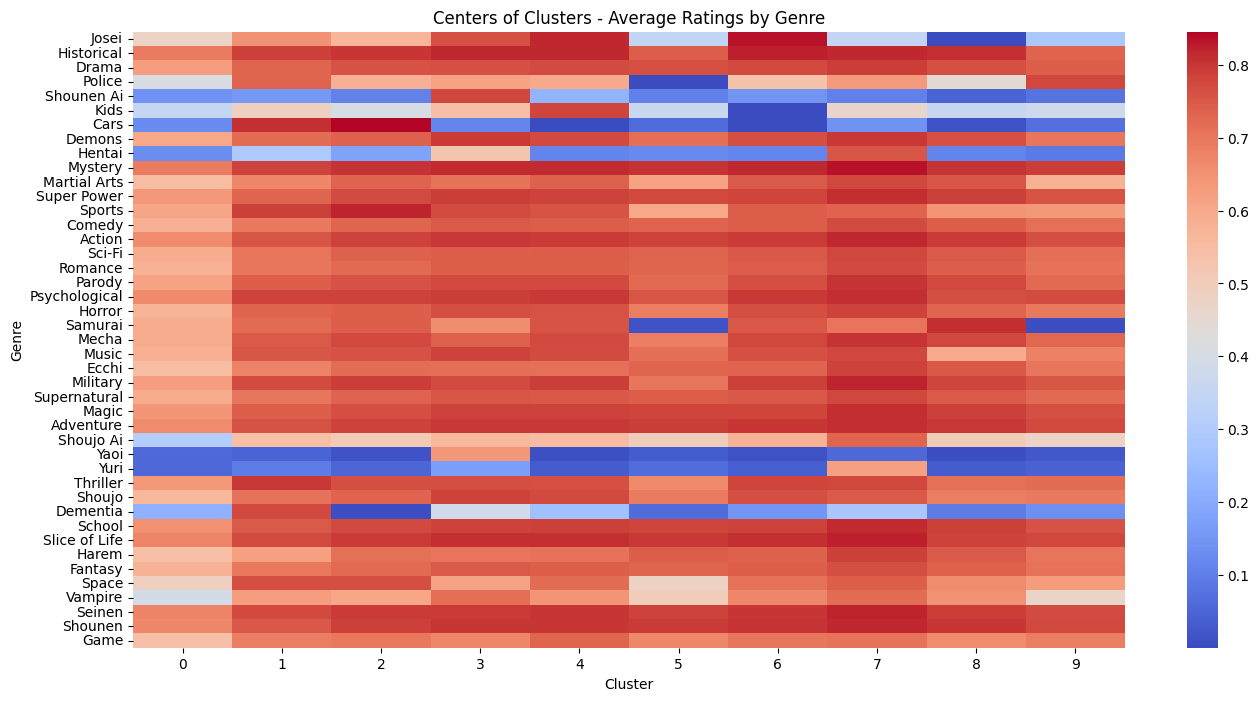

In [57]:
cluster_centers = marked_df.groupby('cluster')[genres].mean()

plt.figure(figsize=(16, 8))
sns.heatmap(cluster_centers.T, cmap='coolwarm', cbar=True)
plt.title('Centers of Clusters - Average Ratings by Genre')
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/29 [00:00<00:15,  1.82it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/29 [00:01<00:26,  1.01it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|█         | 3/29 [00:03<00:30,  1.17s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

Text(0, 0.5, '$J(C_k)$')

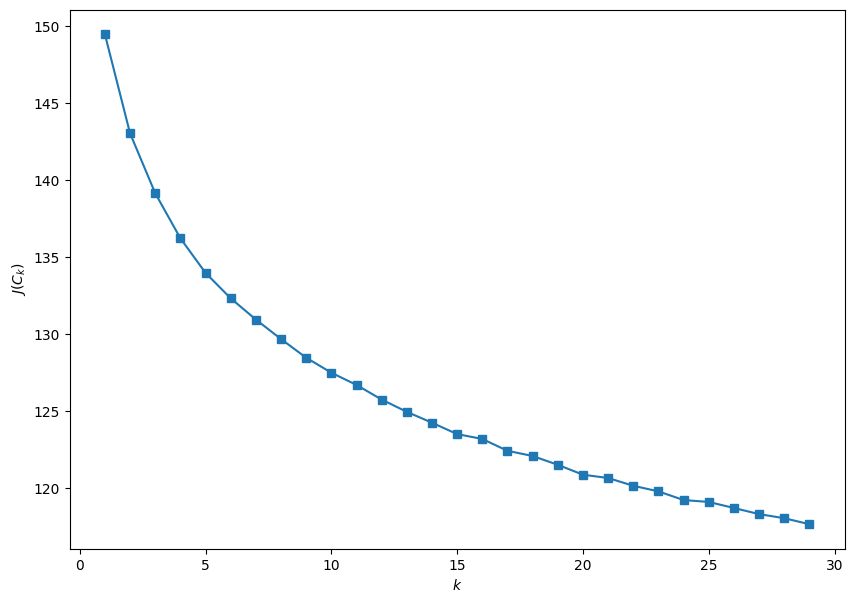

In [58]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [59]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  4%|▎         | 1/28 [00:03<01:38,  3.65s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/28 [00:08<01:59,  4.60s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█         | 3/28 [00:12<01:43,  4.14s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

2

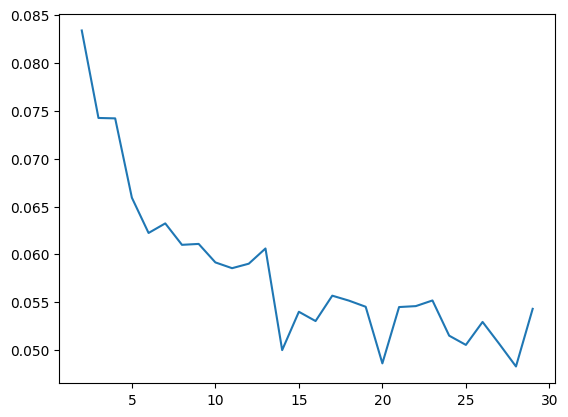

In [60]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


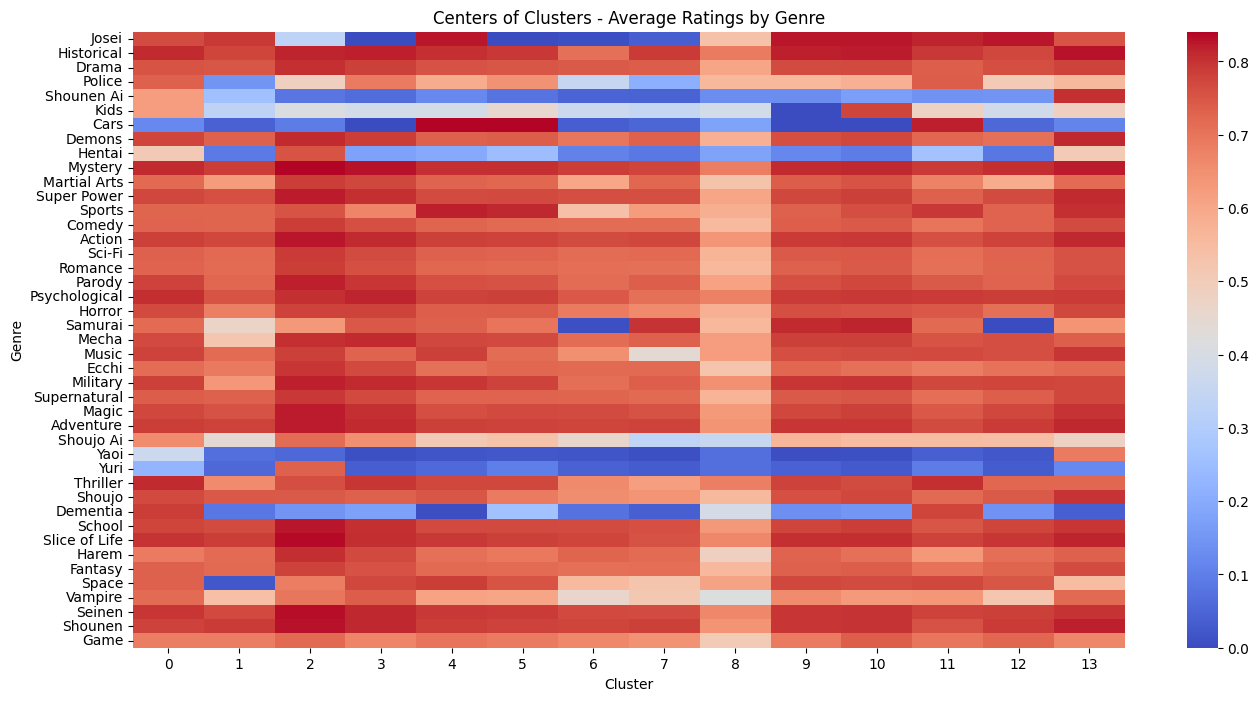

In [67]:
kmeans_opt = KMeans(n_clusters=14, random_state=25)
kmeans_opt.fit(df)

marked_opt = df.copy()
marked_opt['cluster'] = kmeans_opt.labels_

cluster_centers_opt = marked_opt.groupby('cluster')[genres].mean()

plt.figure(figsize=(16, 8))
sns.heatmap(cluster_centers_opt.T, cmap='coolwarm', cbar=True)
plt.title('Centers of Clusters - Average Ratings by Genre')
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю.
Это можно сделать разными способами. Как это сделать подумайте сами.

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен.
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



**Ответ**

1. Поиск кластера пользователя: Определить кластер, к которому относится абстрактный пользователь. Это можно сделать, например, путем предсказания кластера для нового пользователя или по схожести его предпочтений с центрами кластеров.

2. Получение предпочтений кластера: Для выбранного кластера получить список предпочитаемых жанров, отсортированных по средней оценке пользователей этого кластера. Таким образом, вы узнаете, какие жанры наиболее ценятся в данном кластере.

3. Рекомендация аниме: Используя список предпочитаемых жанров кластера, отфильтровать аниме, которые соответствуют этим жанрам. Затем отсортировать отфильтрованный список аниме по среднему рейтингу, чтобы порекомендовать пользователю аниме с наилучшими оценками в том жанре, который наиболее интересен его кластеру.

### Extra. Попробуйте как-нибудь улучшить эту рекомендашку. Приведите код или рассуждения на эту тему.

Если писать код, то можно:
 * каждому жанру присвоить свой вес, так как одних жанров сильно много и у них разная смысловая нагрузка. Комедии и экшн встречаются очень часто и врядли кто-то только из-за этих жанров будет смотреть аниме.
 * предсказывать не по жанрам, а по аниме. Там получится очень большая размерность, так как нужно сделать one-hot-encoding по аниме, но может это даст лучше результат(спойлер: нет). (И для этого надо сделать 4 join'а, что, возможно, убьет ваш компьютер или/и мозг)

**Ответ**

1. Учет нескольких лучших жанров: Вместо того чтобы рассматривать только один наиболее предпочитаемый жанр кластера, можно учитывать несколько лучших жанров. Это может увеличить разнообразие рекомендаций и учесть более широкий спектр интересов пользователей.

2. Персонализированные рекомендации: Если у вас есть информация о предпочтениях абстрактного пользователя (например, история просмотров или лайков), можно интегрировать эту информацию в систему рекомендаций для учета индивидуальных предпочтений.

3. Использование контента: Дополнительно можно рассматривать не только рейтинги и жанры, но и другие атрибуты контента, такие как описание, актеры, режиссеры и т.д., чтобы делать более глубокие и разнообразные рекомендации.